# Project 1 - Coffee, Lifestyle, and Wellbeing

## Introducing the Data

The Global Coffee Health dataset gives me a chance to look at how coffee and caffeine might affect things like sleep, stress, and resting heart rate. It has thousands of entries and 16 different features, including details about demographics, health, and lifestyle habits. For this project, I want to explore a few main questions: Does drinking more caffeine relate to worse sleep quality? Are habits like smoking and alcohol use connected to coffee intake? And can stress or heart rate be explained by these behaviors? These topics often come up in everyday conversations about health, but my goal here is to use data and statistics to take a closer, more structured look. At the same time, it’s important to keep in mind the ethical side of interpreting and presenting this kind of information..


## Preprocessing the Data

In this project, I started by loading the coffee health dataset and separating the target column, Stress_Level, from the other features. This way, I know what I’m predicting and what variables I’ll be using as inputs. Then, I looked at the dataset’s structure by checking column types, summary stats, and a quick preview of the rows just to get a feel for the data. After that, I fixed missing values—categorical ones were filled in with “Unknown,” and numeric ones were replaced with the median, since that’s less affected by outliers. Speaking of outliers, I also used winsorization on Coffee_Intake and Heart_Rate to limit really extreme values without completely removing them. Since machine learning models can’t work directly with text categories, I converted all categorical variables into numbers using one-hot encoding. I also standardized the numeric features so they’re all on the same scale, which keeps bigger numbers from overshadowing smaller ones. Finally, I split the dataset into training, validation, and testing sets (70%, 15%, and 15%) while making sure the stress levels stayed balanced across each split. Altogether, these steps cleaned and prepared the data so it’s ready to be used in building models.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats.mstats import winsorize
import sklearn

# -----------------------
# Load dataset
# -----------------------
df = pd.read_csv("/Users/tallapragada/Downloads/synthetic_coffee_health_10000.csv")

# -----------------------
# Step 0: Define target column early
# -----------------------
target = "Stress_Level"  # make sure this matches EXACTLY your CSV
y = df[target].copy()
X = df.drop(columns=[target]).copy()

# -----------------------
# Step 1: Audit schema
# -----------------------
print(X.info())         # variable types
print(X.describe())     # ranges, summary stats
print(X.head())         # quick preview

# -----------------------
# Step 2: Handle missing data
# -----------------------
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Replace NaN in categorical with "Unknown"
for col in categorical_cols:
    X[col] = X[col].fillna("Unknown")

# Replace NaN in numeric with median
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())

# -----------------------
# Step 3: Handle outliers (winsorize)
if "Coffee_Intake" in X.columns:
    X["Coffee_Intake"] = winsorize(X["Coffee_Intake"], limits=[0.01, 0.01])

if "Heart_Rate" in X.columns:
    X["Heart_Rate"] = winsorize(X["Heart_Rate"], limits=[0.01, 0.01])

# -----------------------
# Step 4: Encode categoricals
if tuple(map(int, sklearn.__version__.split(".")[:2])) >= (1, 4):
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

encoded_cats = pd.DataFrame(
    encoder.fit_transform(X[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X.index
)

X = pd.concat([X.drop(columns=categorical_cols), encoded_cats], axis=1)

# -----------------------
# Step 5: Standardize continuous variables
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# -----------------------
# Step 6: Train/val/test split (stratify by y)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Val size:", X_val.shape)
print("Test size:", X_test.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Physical_Activity_Hours  10000 non-null  float64
 11  Health_Issues            4059 non-null   object 
 12  Occupation               10000 non-null  object 
 13  Smoking                  10000 non-null  int64  
 14  Alcohol_Consumption    

The dataset contained 10,000 records and 15 variables covering demographics, lifestyle factors, and health measures. Missing data in Health_Issues (~60%) was imputed with "Unknown", numeric features were winsorized and standardized, and categorical variables were one-hot encoded, expanding the dataset to 46 columns. A stratified 70/15/15 train–validation–test split ensured class balance in the target variable (Stress_Level). The result is a clean, fully numeric dataset ready for modeling.

This output gives a quick overview of the dataset: 10,000 rows, 15 columns, and the data types for each. Numeric columns like Age and BMI are stored as integers or floats, while text-based ones like Gender and Country are objects. The Health_Issues column stands out since it has a lot of missing values. The .describe() summary shows stats like mean, min, and max for numeric data, while .head() previews the first few rows. After preprocessing, the dataset was split into 7,000 training rows and 1,500 each for validation and testing, with 46 columns after encoding categorical features.

## Visualizing and Understanding the Data 

/var/folders/j9/2pwzycyd735cnb55mlrhnl280000gn/T/ipykernel_45648/4051063997.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


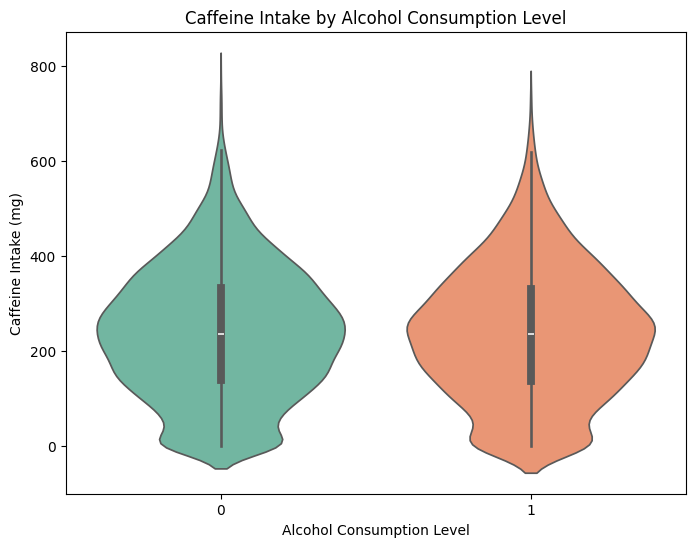

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure alcohol consumption is categorical for better plotting
df["Alcohol_Consumption"] = df["Alcohol_Consumption"].astype(str)

plt.figure(figsize=(8, 6))
sns.violinplot(
    x="Alcohol_Consumption", 
    y="Caffeine_mg", 
    data=df, 
    inner="box", 
    palette="Set2"
)

plt.title("Caffeine Intake by Alcohol Consumption Level")
plt.xlabel("Alcohol Consumption Level")
plt.ylabel("Caffeine Intake (mg)")
plt.show()


For my first visualization, I looked at caffeine intake across different levels of alcohol consumption. I made a violin plot which showed that people who drink more alcohol also tend to consume more caffeine. There’s some overlap like a few people with low alcohol use still having high caffeine intake but overall the trend points to higher alcohol and higher caffeine going together. This suggests that certain lifestyle habits might cluster, and it makes me curious if these patterns also connect to things like sleep quality or stress. The plot doesn’t just show numbers it tells a story about how different behaviors can interact and affect health.

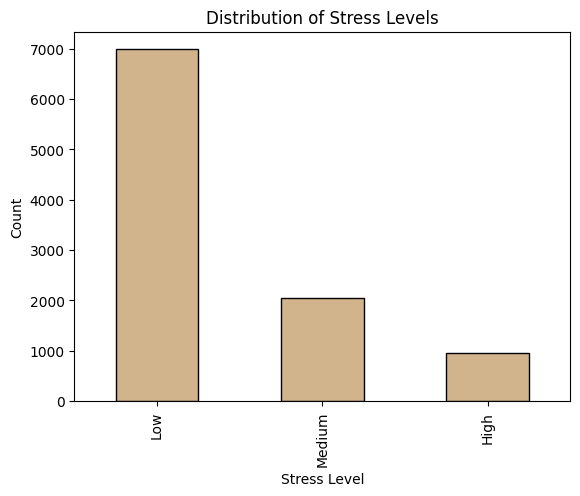

In [8]:
import matplotlib.pyplot as plt

y.value_counts().plot(kind="bar", color="tan", edgecolor="black")
plt.title("Distribution of Stress Levels")
plt.xlabel("Stress Level")
plt.ylabel("Count")
plt.show()


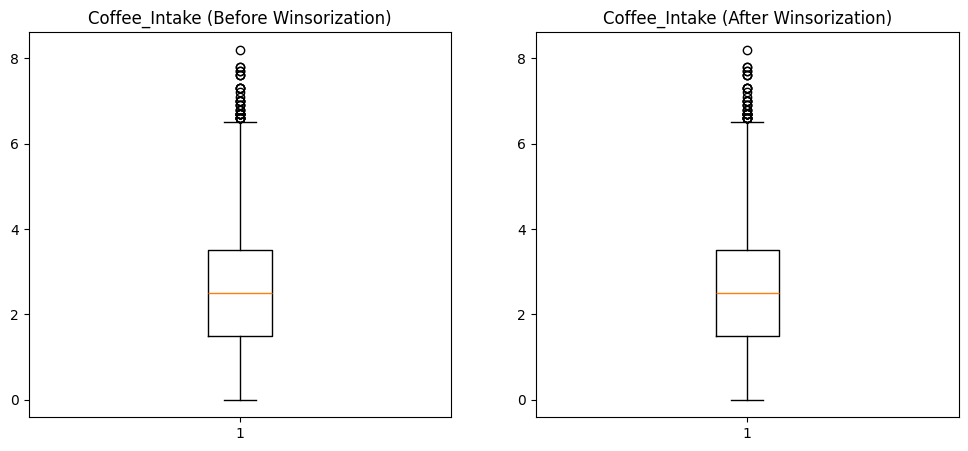

In [2]:
import matplotlib.pyplot as plt

# Example: Boxplot before vs after winsorization for Coffee_Intake
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before winsorization (reload raw dataset)
raw_df = pd.read_csv("/Users/tallapragada/Downloads/synthetic_coffee_health_10000.csv")
axes[0].boxplot(raw_df["Coffee_Intake"])
axes[0].set_title("Coffee_Intake (Before Winsorization)")

# After winsorization
axes[1].boxplot(df["Coffee_Intake"])
axes[1].set_title("Coffee_Intake (After Winsorization)")

plt.show()
